## A decision support system for Glaucoma diagnosis.
### Feature Selection

Here we attempt to find sets of variables which have the greatest potential for use in a predictive model for Glaucoma diagnosis.

The data are from 638 patients who underwent exams for glaucoma at several ophthalmology clinics in Boston. Variables included are:
 
**1)** A **diagnosis**: positive or negative, for glaucoma.

**2) Demographic variables**: age, race, gender.

**3) Intraocular pressure ('IOP')**: determined by tonometry. This is the result of a standard 'puff test' given in optometry and ophthalmolgy clinics to messure the fluid pressure inside the eye. It is generally the first indicator of risk for glaucoma. For most of the patients in this dataset, high IOP has been found prior to administering the other tests and they have already received some treatment to reduce it. As such, IOP is unlikely to be a useful predictor of positive diagnosis.  

**4) Retinal anatomy variables**: 2  variables giving the results of retinal exams : cup-to-disk ratio ('cdratio') and retinal nerve fiber layer thickness ('avgthickness').

**5) Visual acuity variables**: The results of 4 vision tests: glaucoma hemifield test ('ght'), visual field index ('vfi'), mean pattern deviation ('msdonl'), and pattern standard deviation ('psdonl').



In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import operator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import mca
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


There is an additional variable 'suspect' which we can remove as it's not informative regarding diagnosis. 

In addition, 43 patients have GHT scores above '3' indicating an indecisve result of the test. We'll remove those as well. 

Age is given in 'days' so we'll convert those to 'years'.

Three of the vision test variables, GHT, MDONL, and PSDONL are continuous but have already been thresholded to indicate values within or 'outside of normal limits' (onl).

In [6]:
# read the data, create at copy
df0 = pd.read_csv('~/Dropbox/BayesNet/TE_JA151216.csv')
df1 = pd.DataFrame.copy(df0)

# remove 'suspect' column
del df1['suspect']

# remove rows with NaNs
for index, row in df1.iterrows():
    if any([np.isnan(i) for i in row.values]):
        df1.drop(index, inplace=True)
  
# drop patients with GHT >= 4
df1.drop(df1[df1['ght'] >= 4].index, inplace=True)

# reindex
df1.index = range(len(df1))

# age is given in 'days', convert to years
df1['age'] = df1['age']/365


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 11 columns):
glaucoma        597 non-null float64
age             597 non-null float64
race            597 non-null float64
male            597 non-null int64
cdratio         597 non-null float64
IOP             597 non-null float64
avgthickness    597 non-null int64
ght             597 non-null int64
vfi             597 non-null int64
mdonl           597 non-null int64
psdonl          597 non-null int64
dtypes: float64(5), int64(6)
memory usage: 51.4 KB


## Univariate analysis

### Feature histograms

First we can look at how each variable is distributed within the dataset. 

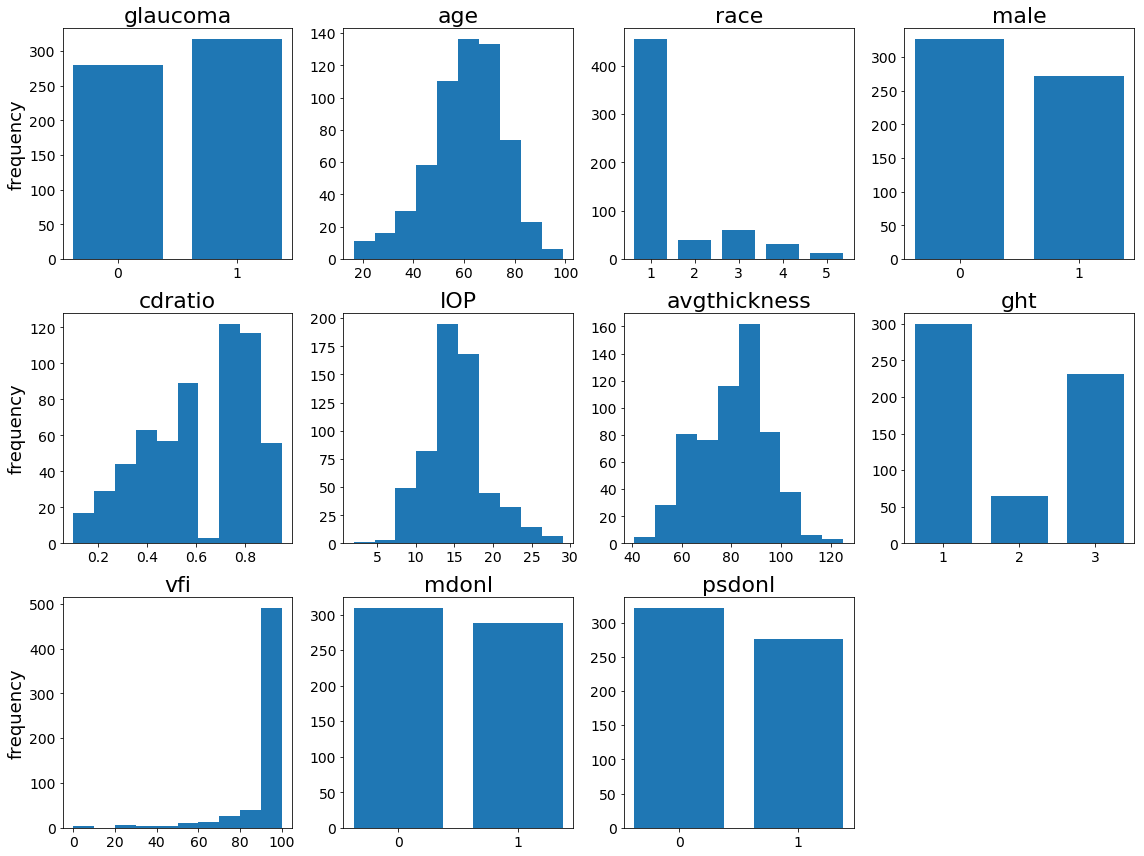

In [3]:

plt.figure(figsize = (16,12))

# get bins for discrete variables
def bin_edges(u): 
    u = sorted(u)
    d = (u[1] - u[0])
    edges = u - d/2
    edges = np.append(edges, edges[-1]+d)
    return edges

sp = 1     
for key in df1.keys().values:
    plt.subplot(3, 4, sp)
    if len(df1[key].unique()) < 10:
        plt.hist(df1[key], bins=bin_edges(df1[key].unique()), rwidth=.75)
        plt.xticks(sorted(df1[key].unique()))
    else:    
        plt.hist(df1[key])
    if sp in [1, 5, 9]:
        plt.ylabel('frequency', fontsize=18)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.title(key, fontsize=22)
    sp = sp + 1
plt.tight_layout()
plt.show()


The 'glaucoma' histogram shows the distribution of negative and positive diagnoses. They are roughly equally distributed in the dataset providing adequate support for the predictions.

The 'race' histogram shows a substantial inbalance, with most patients falling into category 1: 'European descent'. The other categories, Asian (2), African (3), and Hispanic (4) descent, and 'other, mixed, or NA' (5), are sparsely represented in the dataset. 

GHT consists of three categories, 'within normal limits', 'borderline', and 'outside of normal limits'. While borderline cases are sparsely represented, we'll determine below whether it's still a useful feature.

Values of the VFI indicate a spectrum ranging from 0, blindness, to 1, full vision. The distribution of VFI scores is disproportionately high.

_________________________

### Joint feature/diagnosis histograms


Next we can look at how predictive each variable is of a positive diagnosis. 

We'll start by plotting 2D histograms with each variable as a function of diagnosis.

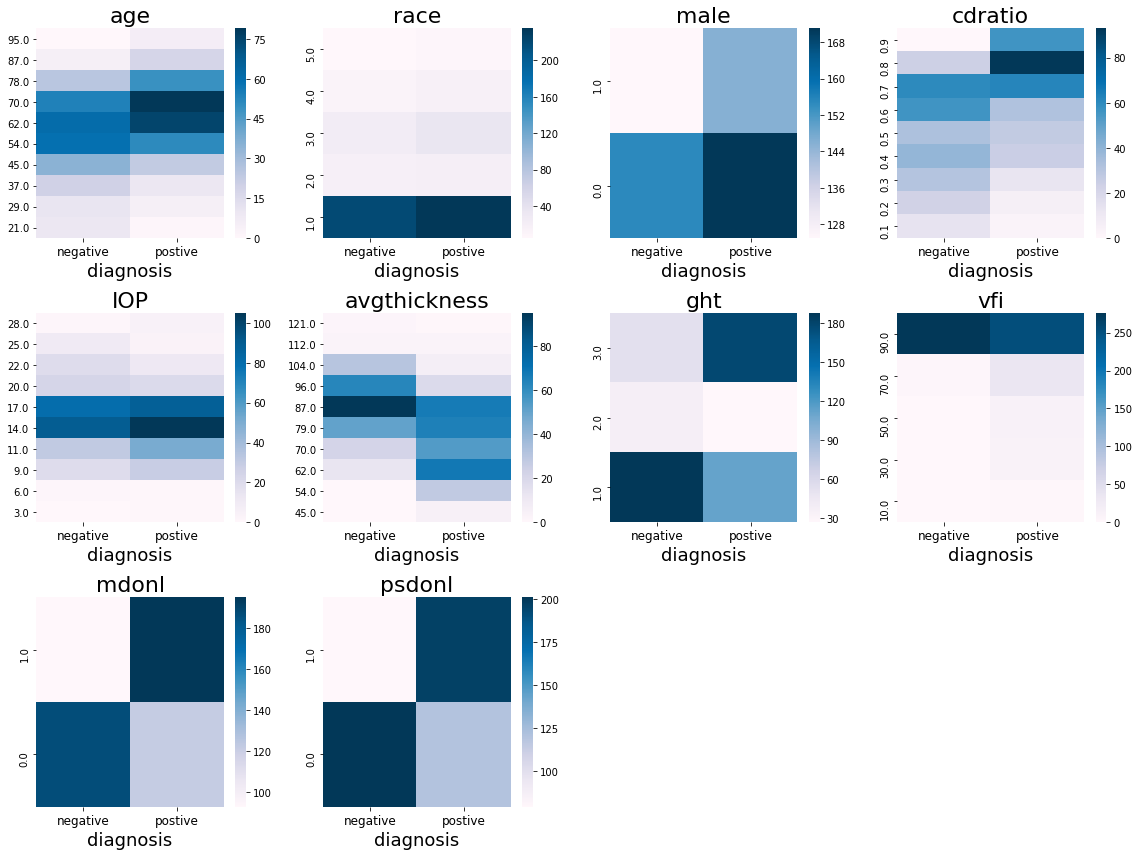

In [4]:
# look at joint histograms  - each IV as a function of Diagnosis

# get bin centers from edge array
def bin_centers(a): 
    return a[:-1] + (a[1] - a[0])/2

# better bins for the variables
bins = {'glaucoma': 2,
        'age': 10,
        'race': 5,
        'male': 2,
        'cdratio': 9,
        'IOP': 10,
        'avgthickness': 10,
        'ght': 3,
        'vfi': 5,
        'mdonl': 2,
        'psdonl': 2}

# create dict for result
H2d = dict.fromkeys(df1.keys())
H2d.pop('glaucoma')

plt.figure(figsize = (16,12))
sp = 1
for key in H2d.keys():
    H2d[key] = np.histogram2d(df1[key], df1['glaucoma'], bins=(bins[key], bins['glaucoma'] ))
    ax = plt.subplot(3, 4, sp)
    if key == 'cdratio':
        r = 1
    else:
        r = 0
    ytlabels = np.round(bin_centers(H2d[key][1][::-1]), r)
    sns.heatmap(np.flipud(H2d[key][0]), cmap='PuBu', ax=ax, annot=False, 
                yticklabels=ytlabels, xticklabels=['negative', 'postive'])
    ax.set_xlabel('diagnosis', size=18)
    ax.set_title(key, size=22)
    sp = sp + 1
    #plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


The most informative features with respect to the diagnoses appear to be 'cdratio', 'avgthickness', 'ght', 'mdonl', and 'psdonl'. Each of these features show peak frequencies that diverge to a large extent between the positive and negative diagnoses. 'Age' shows a somewhat divergent peak with older patients more frequently receiving positive diagnoses. The other features do not diverge substantially between the diagnoses.

_____________________________________

### More feature/diagnosis comparisons
### Correlation


Next we can try 3 methods for assessing the predictiveness of each variable. First is correlation.


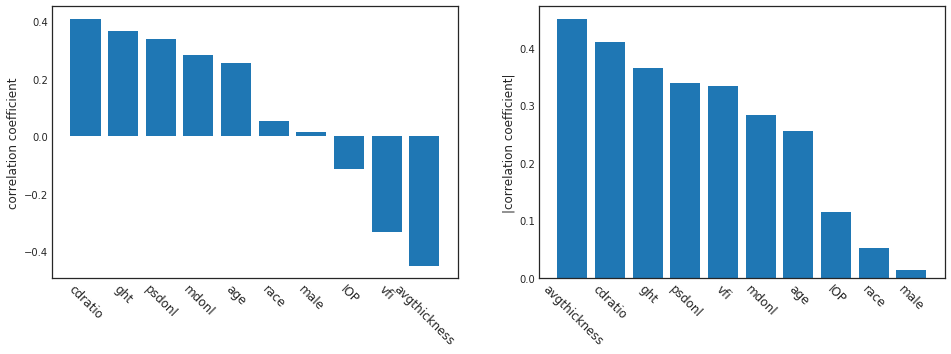

In [5]:
# correlate each IV with diagnosis
Xvars = df1.keys().values[1:]
Y = df1['glaucoma']

# indicate dichotomous variables
is_dichot = [0, 0, 1, 0, 0, 0, 0, 0, 1, 1] 
dichot = dict([(Xvars[i], is_dichot[i]) for i in range(len(Xvars))])

R = dict([(key,0) for key in Xvars])
P = dict([(key,0) for key in Xvars])

for key in Xvars:
    if dichot[key]:
        # if both IV and DV are dichotomous, do Pearson's r
        r, p = stats.pearsonr(df1[key], Y)
    else:
        # if only the DV is dichotomous, do point-biserial correlation
        r, p = stats.pointbiserialr(df1[key], Y)
    R[key] = r
    P[key] = p

# get absolute value of the correlations and sort    
R_abs = dict([(key, abs(item)) for key, item in R.items()]) 
R_sort = list(zip(*sorted(R.items(), key=operator.itemgetter(1), reverse=True)))
R_sort_abs = list(zip(*sorted(R_abs.items(), key=operator.itemgetter(1), reverse=True)))

# plot corrs
sns.set_style('white')
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
plt.bar(range(len(R_sort[1])), R_sort[1])
plt.xticks(range(len(R_sort[1])), R_sort[0], rotation=-45, fontsize=12 )
plt.ylabel('correlation coefficient', fontsize=12)

# plot abs corrs
ax2 = fig.add_subplot(1,2,2)
plt.bar(range(len(R_sort_abs[1])), R_sort_abs[1])
plt.xticks(range(len(R_sort_abs[1])), R_sort_abs[0], rotation=-45, fontsize=12 )
plt.ylabel('|correlation coefficient|', fontsize=12)

plt.show()


Avgthickness, CDR, GHT, and PSD have the highest magnitude correlations with diagnoses.

These are the 2 retinal exam variables followed by the 2 best vision tests.  

Race and Gender are not significantly correlated with diagnosis.
_________________
### Logistic regression

Next we'll regress the continuous variables onto diagnosis and do $\chi^2$ tests for the discreet variables.

In [6]:
# logisitc regression
def do_log_reg(IV, DV):
    IV = IV.tolist()
    DV = DV.tolist()
    IN = np.ones((len(IV),1))
    X = np.column_stack((IV, IN))
    logit = sm.Logit(DV, X)
    return(logit.fit(disp=0))

result = {}

# logisitic regression for the continuous variables
for key in ['age', 'cdratio', 'IOP', 'avgthickness']:
    result[key] = do_log_reg(df1[key], df1['glaucoma'])
    print('{}: params = {}, \n\tp = {}, \n\tr2 = {}\n'.format(key, result[key].params, 
                                                                   result[key].pvalues, 
                                                                   result[key].prsquared))
# chi2 tests for the discrete variables                                                                      
for key in ['race', 'male', 'ght', 'vfi', 'mdonl', 'psdonl']:
    result[key] = stats.chi2_contingency(H2d[key][0])
    print('{}: chi2 = {}, \n\tp = {}\n'.format(key, result[key][0], result[key][1]))


age: params = [ 0.03806721 -2.19258759], 
	p = [  1.59319377e-09   2.51098073e-08], 
	r2 = 0.04883468801155044

cdratio: params = [ 4.41355445 -2.5403924 ], 
	p = [  1.45716892e-20   5.57672487e-17], 
	r2 = 0.12937850377234295

IOP: params = [-0.06118046  1.06116489], 
	p = [ 0.00534499  0.00219731], 
	r2 = 0.009623154840990189

avgthickness: params = [-0.07913934  6.54964217], 
	p = [  2.59209590e-23   2.20975505e-23], 
	r2 = 0.16250439763704128

race: chi2 = 2.0040832186910795, 
	p = 0.7350078167589866

male: chi2 = 0.06965304311792418, 
	p = 0.7918426200006236

ght: chi2 = 85.42572968025122, 
	p = 2.818632749464155e-19

vfi: chi2 = 52.508557908968, 
	p = 1.0798072036819082e-10

mdonl: chi2 = 46.5615170933495, 
	p = 8.878687875820156e-12

psdonl: chi2 = 67.5016686277653, 
	p = 2.1050885527364012e-16



This is giving us information similar to the correlations:

All variables have significant tests other than Race and Gender.

Avgthickness (AVGt) and CDR both have relatively high $r^2$ values. The first parameter value is the regression slope which gives an indication of how the probability of a positive diagnosis changes with a unit change in the variable. CDR has a higher slope than AVGT indicating that it may be a more sensitive indicator. 
______________________

### Mutual information

Next we'll compare the mutual information of each variable with regards to diagnosis. The results should be comparable to the correlation coefficients.

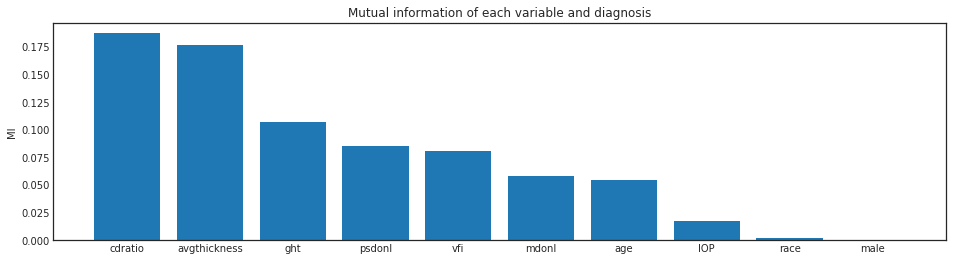

In [7]:
# mutual information
def MI(data, key1, key2, bins):
    # marginal histograms
    h1 = np.histogram(data[key1], bins = bins[key1])[0]
    h2 = np.histogram(data[key2], bins = bins[key2])[0]
    # joint histogram
    h12 = np.histogram2d(data[key1], data[key2], bins = [bins[key1], bins[key2]])[0]
    # marginal and joint probabilities
    marg_1 = h1/np.sum(h1)
    marg_2 = h2/np.sum(h2)
    joint = h12/np.sum(h12)
    # get joint probs assuming independence
    marg_prod = np.outer(marg_1, marg_2)
    # KL divergence
    Dkl = np.log2(np.true_divide(joint,marg_prod))
    # mutual information
    MI = np.sum(np.nan_to_num(np.multiply(joint, Dkl)))
    return MI

# MI for each IV vs the DV
vars = ['age', 'race', 'male', 'cdratio', 'IOP', 'avgthickness', 'ght', 'vfi', 'mdonl', 'psdonl']
MInf_IVDV = dict.fromkeys(vars, [])
for key, values in MInf_IVDV.items():
    MInf_IVDV[key] = MI(df1, key, 'glaucoma', bins)

# the MIs    
sortd = sorted(MInf_IVDV.items(), key=operator.itemgetter(1), reverse=True)
slist = list(zip(*sortd))

# plot
plt.figure(figsize=(16,4))
plt.bar(range(len(slist[1])), slist[1])
plt.xticks(range(len(slist[1])), slist[0])
plt.ylabel('MI')
plt.title('Mutual information of each variable and diagnosis')
plt.show()


Again, Avgthickness and CDR seem to offer to most information about diagnosis followed by GHT and PSD.
____________________

## Summary so far
1. race and gender will likely not be useful due their non-representative distributions and low correlations with diagnosis.
2. CDR and AVGt are most predictive followed by GHT and PSD. These are our best candidates for inclusion into a predictive model. 

The results suggest that the retinal exams (CDR, AVGt) are the most sensitive predictors of a positive diagnosis, and that GHT and PSD are the best vision tests to consider. Intuitively, a good predictive model for Glaucoma diagnosis will include the results of both retinal and vision tests, i.e. assessments of physiological abnormalities of the eye and of the patient's functional vision.

In order to find the best combination of these variables, we need to consider the degree to which they're correlated with each other. We'll do that below.


## Joint feature/feature comparisons

First we'll calculate the correlation of each feature with the other features.

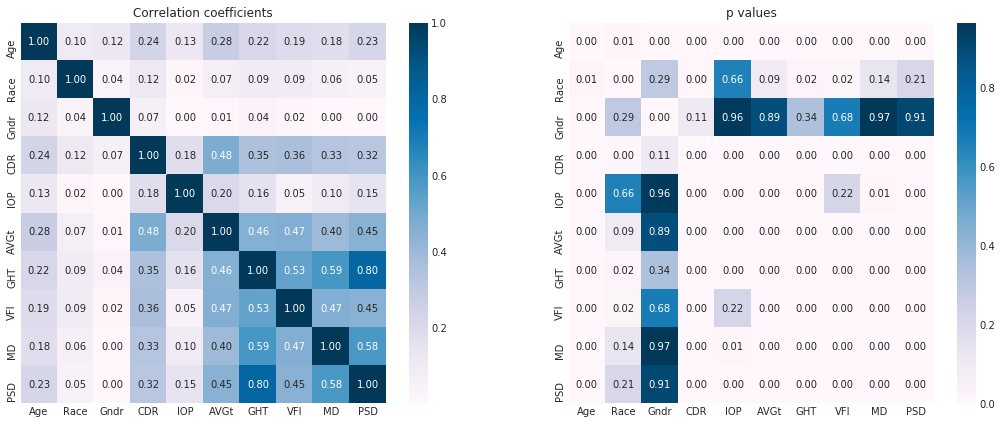

In [17]:
# get independent variables
Xvars = ['age', 'race', 'male', 'cdratio', 'IOP', 'avgthickness', 'ght', 'vfi', 'mdonl', 'psdonl']

# index dichotomous variables
is_dichot = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]

R = np.zeros([len(Xvars), len(Xvars)])
P = np.zeros([len(Xvars), len(Xvars)])

# do point biserial correlation for dicho/cont variables
# Pearson's r otherwise
for i in range(len(Xvars)):
    for j in range(len(Xvars)):
        if is_dichot[i] == is_dichot[j]:
            r, p = stats.pearsonr(df1[Xvars[i]], df1[Xvars[j]])
        else:
            r, p = stats.pointbiserialr(df1[Xvars[i]], df1[Xvars[j]])
        R[i][j] = r
        P[i][j] = p

# plot
labels = ['Age', 'Race', 'Gndr', 'CDR', 'IOP', 'AVGt', 'GHT', 'VFI', 'MD', 'PSD']
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,2, 1)
sns.heatmap(abs(R), annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap='PuBu', ax=ax1)
plt.title('Correlation coefficients')

ax2 = fig.add_subplot(1,2,2)
sns.heatmap(P, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap='PuBu', ax=ax2)
plt.title('p values')

plt.show()

We can see, unsurprisingly, that the two best retinal variables, CDR and AVGt are highly correlated (r = .48), and the two best vision test variables, GHT and PSD, are highly correlated (r = .8). 

The retinal exams and vision tests are strongly correlated with each other as well, although AVGt is somewhat more highly correlated with both vision tests than CDR.

Due to their high degree of multicolinearity, including all 4 of these variables in a predictive model may produce results that are misleading in terms of the relative importance placed on each variable in predicting the diagnosis.

However, it may possible to find optimal combinations of the variables that are more sensitive predictors than each variable alone. We'll try that below.
____________________

## Optimal combination of features

First we'll plot the joint distributions of positive and negative diagnoses for each of the paired retinal exam and vision test variables. This will give us an idea as to whether combining each pair into a single variable will be useful.

### CDR and AVGt

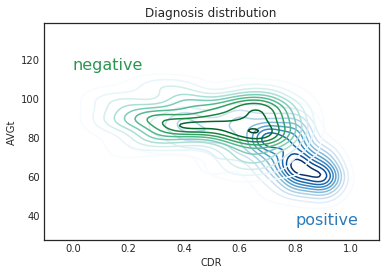

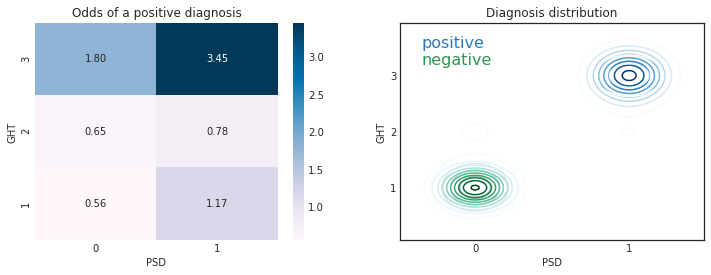

In [22]:
# kde plot - joint distributions of positive and negative diagnoses for CDR and avgthickness
plt.figure()
ax = sns.kdeplot(df1.loc[df1['glaucoma']==1, 'cdratio'], df1.loc[df1['glaucoma']==1, 'avgthickness'], cmap='Blues')
ax = sns.kdeplot(df1.loc[df1['glaucoma']==0, 'cdratio'], df1.loc[df1['glaucoma']==0, 'avgthickness'], cmap='BuGn')
blues = sns.color_palette("Blues")[-2]
BuGn = sns.color_palette("BuGn")[-2]
ax.text(.8, 35, "positive", size=16, color=blues)
ax.text(0, 115, "negative", size=16, color=BuGn)
plt.title('Diagnosis distribution')
plt.xlabel('CDR')
plt.ylabel('AVGt')

# joint histograms for GHT and PSD
ght_psd_pos = np.histogram2d(df1.loc[df1['glaucoma']==1, 'ght'],df1.loc[df1['glaucoma']==1, 'psdonl'],
                             bins=(bins['ght'], bins['psdonl']))
ght_psd_neg = np.histogram2d(df1.loc[df1['glaucoma']==0, 'ght'],df1.loc[df1['glaucoma']==0, 'psdonl'],
                             bins=(bins['ght'], bins['psdonl']))

# heatmap of the joint histogram
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
#sns.heatmap(np.flipud(ght_psd_pos[0]/(ght_psd_pos[0]+ght_psd_neg[0])), cmap='PuBu', ax=ax1,
#           yticklabels=[3, 2, 1], annot=True, fmt='.2f')
sns.heatmap(np.flipud(ght_psd_pos[0]/ght_psd_neg[0]), cmap='PuBu', ax=ax1,
           yticklabels=[3, 2, 1], annot=True, fmt='.2f')
ax1.set_xlabel('PSD')
ax1.set_ylabel('GHT')
ax1.set_title('Odds of a positive diagnosis')

# kde plot
ax2 = fig.add_subplot(1,2,2)
sns.kdeplot(df1.loc[df1['glaucoma']==1, 'psdonl'], df1.loc[df1['glaucoma']==1, 'ght'], cmap='Blues', ax=ax2)
sns.kdeplot(df1.loc[df1['glaucoma']==0, 'psdonl'], df1.loc[df1['glaucoma']==0, 'ght'], cmap='BuGn', ax=ax2)
ax2.xaxis.set_ticks([0, 1])
ax2.yaxis.set_ticks([1, 2, 3])
ax2.text(-.35, 3.5, "positive", size=16, color=blues)
ax2.text(-.35, 3.2, "negative", size=16, color=BuGn)
plt.title('Diagnosis distribution')
plt.xlabel('PSD')
plt.ylabel('GHT')

plt.show()


The top plot shows the distributions of positive and negative diagnoses as a function of the 2 retinal variables, AVGt and CDR. It's likely that if the bivariate, AVGt $\times$ CDR, distribution was projected onto a negatively sloping line connectiong the peaks of the positive and negative diagnosis distributions, this may increase the discriminability of the diagnoses.

The bottom plots show the distributions of diagnoses for the 2 vision test variables, GHT and PSD. While a density estimate isn't appropriate for the two discrete variables, the KDE plot on the right makes it easier to visualize the bivariate relationship between positive and negative diagnoses. The positive and negative distributions overlap, but it's still likely that projecting the data onto a positively sloping line connecting the negative (green) and positive (blue) peaks, would increase their discriminability. 

So we can try optimally combining the 2 retinal variables and the 2 vision test variables below, by projecting each bivariate distribution onto its first principle component.



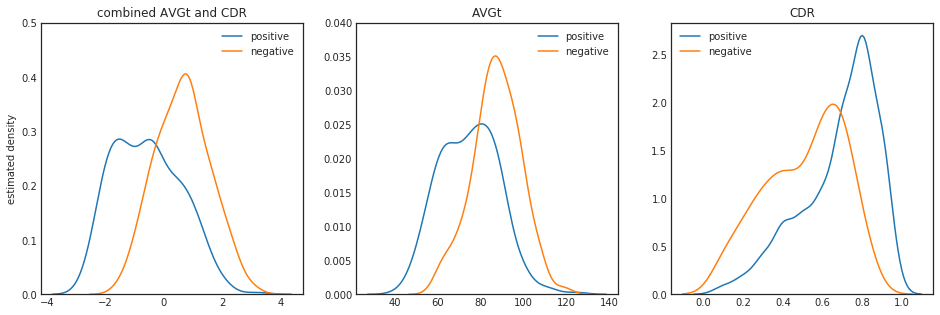

In [23]:
# combine variables

# do PCA on cdr & avgt
X = df1[['cdratio', 'avgthickness']]
X = StandardScaler().fit_transform(X)
pca_cdr_avgt = PCA(n_components=2)
pca_cdr_avgt.fit(X)

# project X onto 1st PC
P = pca_cdr_avgt.components_[0]
cdr_avgt = np.dot(P,X.T)

# add the new variable to the dataframe
df1['cdr_avgt'] = pd.Series(cdr_avgt) 

# get the bivariate and univariate 
# diagnosis distributions for comparison
cdr_avgt_pos = df1.loc[df1['glaucoma'] == 1, 'cdr_avgt']
cdr_avgt_neg = df1.loc[df1['glaucoma'] == 0, 'cdr_avgt']

avgt_pos = df1.loc[df1['glaucoma'] == 1, 'avgthickness']
avgt_neg = df1.loc[df1['glaucoma'] == 0, 'avgthickness']

cdr_pos = df1.loc[df1['glaucoma'] == 1, 'cdratio']
cdr_neg = df1.loc[df1['glaucoma'] == 0, 'cdratio']

# plot 
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,3,1)
sns.kdeplot(cdr_avgt_pos, ax=ax1, label='positive')
sns.kdeplot(cdr_avgt_neg, ax=ax1, label='negative')
ax1.set_ylim([0, .5])
ax1.set_ylabel('estimated density')
ax1.set_title('combined AVGt and CDR')

ax2 = fig.add_subplot(1,3,2)
sns.kdeplot(avgt_pos, ax=ax2, label='positive')
sns.kdeplot(avgt_neg, ax=ax2, label='negative')
ax2.set_ylim([0, .04])
ax2.set_title('AVGt')

ax3 = fig.add_subplot(1,3,3)
sns.kdeplot(cdr_pos, ax=ax3, label='positive')
sns.kdeplot(cdr_neg, ax=ax3, label='negative')
ax3.set_title('CDR')

plt.show()

The left plot shows the distributions of positive and negative diagnoses for the optimal combination of Avg Thickness and CDR. For comparison, the other two plots show the distributions for each of the two, uncombined variables. It appears that combining the variables did increase the separation between the diagnoses. We'll test this below with a simple regression classifier.

Next, we can combine the vision test variables using an implementation of PCA appropriate for categorical variables, Multiple Correspondence Analysis (MCA). MCA transforms the categorical variables into 'dummy' indicator variables and then performs PCA on the concatenated indicator matrix. The result is a set of ranked 'factor loadings' analogous to principle components.

### GHT and PSD

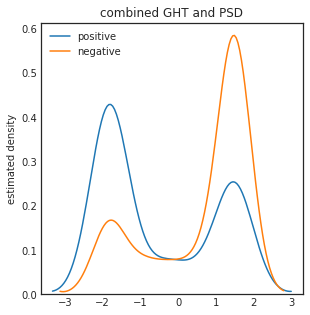

In [26]:
# do MCA on ght & psd

# get the variables
X = df1[['ght', 'psdonl']]

# transform into dummy variables
X_ght = pd.get_dummies(df1['ght'])
X_psd = pd.get_dummies(df1['psdonl'])

# create the indicator matrix
XI = pd.concat([X_ght, X_psd], axis=1)

# MCA
mca_gp = mca.MCA(XI.T, ncols=2)

# get the factor loadings
factor_scores = mca_gp.fs_r(N=1)
contributions = mca_gp.cont_r(N=1)

# project onto factor scores
ght_psd = np.dot(factor_scores.T, XI.T)

# we can also try PCA ---------------
#pca_ght_psd = PCA(n_components=2)
#X = StandardScaler().fit_transform(X)
#pca_ght_psd.fit(X)
#print(pca_ght_psd.components_)
#print(pca_ght_psd.singular_values_)
#print(pca_ght_psd.explained_variance_ratio_)
# project X onto 1st PC
#P = pca_ght_psd.components_[1]
#ght_psd = [np.dot(P,X.T)]
# ------------------------------------

# add the new variable to the dataframe
df1['ght_psd'] = pd.Series(ght_psd[0]) 

# get positive and negative diagnosis distributions
# for the combined variables
ght_psd_pos = df1.loc[df1['glaucoma'] == 1, 'ght_psd']
ght_psd_neg = df1.loc[df1['glaucoma'] == 0, 'ght_psd']

# plot the combined variables
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,3,1)
sns.kdeplot(ght_psd_pos, ax=ax1, label='positive')
sns.kdeplot(ght_psd_neg, ax=ax1, label='negative')
ax1.set_title('combined GHT and PSD')
ax1.set_ylabel('estimated density')
plt.show()

While the combined GHT/PSD variable has considerable overlap between the diagnoses, it's still possible that it will be an improvement over the discriminability of the 2 variables alone.

Below, we'll test the new variables with 2 feature selection techniques and see how they compare to the original variables.

In [27]:
# add the new variables to the existing data

# add histogram bins for new variables
bins['cdr_avgt'] = 10
bins['ght_psd'] = 10

# add 2d histograms 
H2d['cdr_avgt'] = np.histogram2d(df1['cdr_avgt'], df1['glaucoma'], bins=(bins['cdr_avgt'], bins['glaucoma'] ))
H2d['ght_psd'] = np.histogram2d(df1['ght_psd'], df1['glaucoma'], bins=(bins['ght_psd'], bins['glaucoma'] ))

# add mutual information 
vars = ['cdr_avgt', 'ght_psd']
for key in vars:
    MInf_IVDV[key] = MI(df1, key, 'glaucoma', bins)

## Feature selection using mRMR

Here we'll choose the best sets of features according the 'mimimum Redundancy Maximum Relevance' criterion (Peng, 2005). This calculates the mutual information of each variable with respect to the diagnoses (already computed above) and then penalizes the score by subtracting the mutual information over the set of predictors. The result give sets of variables that are maximally predictive of the outcome and minimally correlated with each other. 

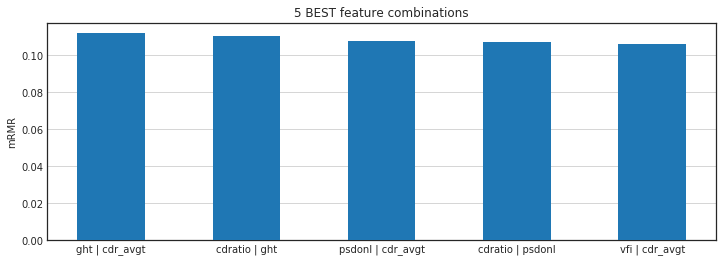

In [31]:
# list the variables (exclude race and gender)
vars = ['age', 'cdratio', 'IOP', 'avgthickness',
       'ght', 'vfi', 'mdonl', 'psdonl', 'cdr_avgt', 'ght_psd'] 

# get their mutual information
MInf_IVIV = pd.DataFrame(index=vars, columns=vars)        
for i in range(MInf_IVIV.shape[0]):
    for j in np.arange(i+1, MInf_IVIV.shape[1]):
        key1, key2 = [MInf_IVIV.keys().values[i], MInf_IVIV.keys().values[j]]
        MInf_IVIV.loc[key1, key2] = MI(df1, key1, key2, bins)

# get MRMR for all set sizes and combinations of the variables        
MRMR = dict()
for combs in np.arange(2,len(MInf_IVIV.columns)+1):
    cc = list(combinations(MInf_IVIV.columns,combs))
    for c in cc:
        new_key = " | ".join(c)
        c_pairs = list(combinations(c, 2))
        mi_c = []
        mi_f = []
        for pair in c_pairs:
            mi_f.append(MInf_IVIV.loc[pair[0], pair[1]])
            for f in pair:
                mi_c.append(MInf_IVDV[f])
        MRMR[new_key] = np.mean(mi_c) - np.sum(mi_f)/(len(c)**2)

# order the MRMR values
mrmr_sort = sorted(MRMR.items(), key=operator.itemgetter(1), reverse=True)
mrmr_zip = list(zip(*mrmr_sort))

# plot the best variable sets
plt.figure(figsize = (12, 4))
plt.bar(range(len(mrmr_sort[0:5])), mrmr_zip[1][0:5], .5, zorder=3)
plt.xticks(range(len(mrmr_sort[0:5])), mrmr_zip[0][0:5], rotation=0)
plt.title('5 BEST feature combinations')
plt.ylabel('mRMR')
plt.grid(axis='y', zorder=0)
plt.show()

# plot the worst sets
#plt.figure(figsize = (12, 4))
#plt.bar(range(len(mrmr_sort[-5:])), mrmr_zip[1][-5:], .5, zorder=3)
#plt.xticks(range(len(mrmr_sort[-5:])), mrmr_zip[0][-5:], rotation='vertical')
#plt.title('5 WORST feature combinations')
#plt.ylabel('mRMR')
#plt.grid(axis='y', zorder=0)
#plt.show()


According to the mRMR criteria, the five best variable sets are pairs incuding one retinal exam and one vision test:

1) CDR_AVGt | GHT 

2) CDR      | GHT

3) CDR_AVGt | PSD

4) CDR      | PSD

5) CDR_AVGt | VFI

AVGt does not appear in the top 5 probably due to its relative lack of sensitivity compared to CDR (and its high correlation with CDR).

But the combined retinal test 'CDR_Avgt' seems to be potentially useful.

Next we can evaluate sets of variables according to their prediction accuracy with a simple regression classifier.
____________________________

## Feature selection using RFE with Ridge Regression

Here we'll try a method of feature selection that relies entirely on predictiveness. We'll do Recursive Feature Elimination (RFE) with a logistic regression model that uses ridge regression to compensate for the multicollinearity of the variables.

### All features

In [33]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics

# function to do RFE with Ridge Regression
def doRFE(data, features, DV, n_train):
    train_ix = range(n_train)
    test_ix = np.arange(n_train, np.shape(data)[0])
    X_train = data.loc[train_ix, features]
    Y_train = data.loc[train_ix, DV]
    X_test = data.loc[test_ix, features]
    Y_test = data.loc[test_ix, DV]
    model = RidgeClassifier(alpha=1)

    results = {'best_model': [], 'rank': [], 'accuracy': []}
    for i in range(len(features)):
        rfe = RFE(model, i+1)
        fit = rfe.fit(X_train, Y_train)
        pred = rfe.predict(X_test)
        acc = metrics.accuracy_score(Y_test, pred)

        # format best features
        f_string = []
        for j in range(len(features)):
            if fit.support_[j]:
                f_string.append(features[j])

        results['best_model'].append(' | '.join(f_string))
        results['rank'].append(fit.ranking_)
        results['accuracy'].append(acc)
    return results

# feature names
features = ['age', 'cdratio', 'IOP', 'avgthickness',
       'ght', 'vfi', 'mdonl', 'psdonl', 'cdr_avgt', 'ght_psd'] 
DV = 'glaucoma'

# ridge RFE 
data = df1
n_train = 500
results = doRFE(data, features, DV, n_train)

print('Best variables for each set size and accuracy:\n')
for i in range(len(results['best_model'])):
    print('{} -- {:.3f}\n'.format(results['best_model'][i],results['accuracy'][i]))           


Best variables for each set size and accuracy:

cdr_avgt -- 0.742

cdratio | cdr_avgt -- 0.763

cdratio | cdr_avgt | ght_psd -- 0.742

cdratio | psdonl | cdr_avgt | ght_psd -- 0.742

cdratio | ght | psdonl | cdr_avgt | ght_psd -- 0.742

cdratio | ght | mdonl | psdonl | cdr_avgt | ght_psd -- 0.753

age | cdratio | ght | mdonl | psdonl | cdr_avgt | ght_psd -- 0.753

age | cdratio | IOP | ght | mdonl | psdonl | cdr_avgt | ght_psd -- 0.763

age | cdratio | IOP | avgthickness | ght | mdonl | psdonl | cdr_avgt | ght_psd -- 0.763

age | cdratio | IOP | avgthickness | ght | vfi | mdonl | psdonl | cdr_avgt | ght_psd -- 0.753



The single best variable is the combined CDR and AVGt. But the remaining results are not very sensible. The best pair is the combination of CDR and CDR-AVGt. As one variable is constructed from the other, their combination does not make for a plausible model. Likewise the larger sets are very redundant, containing features which we've shown above to be highly correlated.

Let's repeat the test leaving out the 2 new variables.

### Original features only

In [34]:
# leave out new variables
# feature names
features = df1.keys().values[1:-2]

DV = df1.keys().values[0]  

# ridge test
data = df1

# number of training cases
n_train = 500

results = doRFE(data, features, DV, n_train)

print('Best variables for each set size and accuracy:\n')
for i in range(len(results['best_model'])):
    print('{} -- {:.3f}\n'.format(results['best_model'][i],results['accuracy'][i])) 
 

Best variables for each set size and accuracy:

cdratio -- 0.753

cdratio | psdonl -- 0.784

cdratio | ght | psdonl -- 0.784

race | cdratio | ght | psdonl -- 0.784

race | cdratio | avgthickness | ght | psdonl -- 0.763

race | cdratio | avgthickness | ght | mdonl | psdonl -- 0.763

race | male | cdratio | avgthickness | ght | mdonl | psdonl -- 0.763

age | race | male | cdratio | avgthickness | ght | mdonl | psdonl -- 0.763

age | race | male | cdratio | IOP | avgthickness | ght | mdonl | psdonl -- 0.763

age | race | male | cdratio | IOP | avgthickness | ght | vfi | mdonl | psdonl -- 0.773



Here the best set (i.e., smallest with highest accuracy) is the pairing of CDR and PSD. This is one of the top 5 from the mRMR test.

Now let's try leaving out each of the individual variables we combined and only test the combinations.

### Combined features 

In [35]:
# now leave out CDR, GHT, AVGT, PSD

# feature names
features = ['age', 'IOP', 'vfi', 'mdonl', 'cdr_avgt', 'ght_psd']

DV = df1.keys().values[0]  

# ridge test
data = df1

# number of training cases
n_train = 500

results = doRFE(data, features, DV, n_train)

print('Best variables for each set size and accuracy:\n')
for i in range(len(results['best_model'])):
    print('{} -- {:.3f}\n'.format(results['best_model'][i],results['accuracy'][i])) 


Best variables for each set size and accuracy:

cdr_avgt -- 0.742

cdr_avgt | ght_psd -- 0.753

mdonl | cdr_avgt | ght_psd -- 0.742

age | mdonl | cdr_avgt | ght_psd -- 0.773

age | IOP | mdonl | cdr_avgt | ght_psd -- 0.784

age | IOP | vfi | mdonl | cdr_avgt | ght_psd -- 0.773



Here the set containing our 2 combined variables CDR_AVGt and GHT_PSD does well. Accuracy is higher for the larger variable sets but this is suspicious considering their redundancies and the lack of predictiveness of the individual variables. These models likely suffer from overfitting. 
___________________

## Conclusions

We've attempted to find candidate sets of variables that have potential for inclusion into a predictive model for glaucoma diagnosis.

According to the univariate and bivariate comparisons, and from a domain-specific perspective, the best model will likely include a combination of retinal exams and vision tests. 

The combination of CDR and AVGt yields an 'optimized' retinal test variable which has high mutual information with the diagnoses and low redundancy.

The combination of GHT and PSD results in an optimal vision test that does well as a classifier when combined with CDR_AVGt

The combination of CDR_AVGt with either of the individual vision tests, PSD or GHT, is also likely to work well. 

The best candidates are:

CDR_AVGt | GHT

CDR_AVGt | PSD

CDR_AVGt | GHT_PSD

CDR | GHT

CDR | PSD

